<!-- # Notebook for Simulating $\hat c_j^i$ Distribution -->

In [1]:
import random
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display, Latex

from numpy import linalg as LA

## Synthetic Linear Dataset


This part, generates synthetic datasets for clustered clients in a distributed learning setup. It produces feature data (`X`) and labels (`y`) for multiple clients across various clusters, simulating data distribution in federated learning environments.

#### Dataset Generation Process:

1. **Mathematical Generation of Features (`X`)**:
   - For each client in a cluster, feature vectors are sampled from a **multivariate normal distribution**. Specifically:
     $
     X_{ijk} \sim \mathcal{N}(0, 1)
     $
     where:
     - $X_{ijk}$ represents the feature vector for the $i_{th}$ cluster, $j_{th}$ client, and $k_{th}$ sample.
     - Each sample has `num_features` dimensions, with each feature value being drawn independently from a normal distribution with mean 0 and variance 1.

2. **Mathematical Generation of Labels (`y`)**:
   - Labels $y_{ijk}$ are generated using a linear model with noise:
     $
     y_{ijk} = X_{ijk} \cdot w_i + \epsilon_k
     $
     where:
     - $w_i$ is a weight vector randomly initialized for each cluster $i$:  $w^i$ ~ $U[-10, 10]$. This vector determines the relationship between features and labels in cluster $i$.
     - $\epsilon_k$ is noise drawn from a normal distribution, $\epsilon_k \sim \mathcal{N}(0, \sigma)$, where $ \sigma $ is controlled by the `noise` parameter.
     - The multiplication $ X_{ijk} \cdot w_i $ represents the dot product between the feature vector $ X_{ijk} $ and the weight vector $ w_i $.

3. **Local Datasets**:
   - After generating the features and labels, they are combined into local datasets for each client, with each client having its own distinct data generated by the model described above. Additionally, the function tracks the cluster assignment for each sample.

#### Output:
The function returns:
- `X`: Feature data for all clusters and clients.
- `y`: Corresponding labels for each feature vector.
- `w`: The weight matrix used for generating labels.
- `clusters`: A list indicating the cluster assignment for each data point.


This method of dataset generation allows for the simulation of distributed or federated learning environments, where each client has unique data, yet some structure is shared within clusters through the cluster-specific weight vectors $w$.

## Configuration

In [2]:
NUM_SAMPLES = 10
NUM_CLIENTS = 50
NUM_CLUSTERS = 2

In [3]:
def get_data(num_features, num_clusters=NUM_CLUSTERS, num_clients=NUM_CLIENTS, num_training_samples=NUM_SAMPLES, noise=0.0):
    w = np.random.uniform(-5,5,(num_clusters,num_features)) # here we shape all w for all clients
    clusters = []

    X = np.zeros ((num_clusters,num_clients,num_training_samples,num_features)) 
    y = np.zeros ((num_clusters,num_clients,num_training_samples))
    localdatasets = np.zeros((num_clusters,num_clients,num_training_samples,(num_features+1)))
    clusterassgts = np.zeros((num_clusters,num_clients,num_training_samples))
    for iter_cluster in range(num_clusters): 
        for iter_node in range(0, num_clients):
            X[iter_cluster, iter_node,:,:] = np.random.randn(num_training_samples, num_features)
            r = X[iter_cluster, iter_node,:,:] @ w[iter_cluster, :].reshape(-1, 1) + np.random.normal(loc=0.0, scale=noise, size=(NUM_SAMPLES, 1))
            y[iter_cluster, iter_node,:] = r.squeeze()
            clusters.append(iter_cluster)
            for iter_sample in range(0,num_training_samples): 
                localdatasets[iter_cluster,iter_node,iter_sample,:] = np.hstack((X[iter_cluster, iter_node,iter_sample,:],y[iter_cluster, iter_node,iter_sample].reshape(-1,))).reshape(1,-1)
                clusterassgts[iter_cluster,iter_node,iter_sample] = iter_cluster


    X = X.reshape(-1, X.shape[2], X.shape[3])
    y = y.reshape(-1, y.shape[2])
    return X, y, w, clusters

## Personalized Federated Learning via Active Sampling for Parametric Models


This function implements an optimization algorithm for **Personalized Federated Learning (PersFL)**, where tailored models are trained for individual clients (e.g., smartphones, wearables) using their local data. The challenge of small, local datasets is addressed by pooling relevant data from similar clients, identified via an **active sampling** method.

#### Algorithm Overview:
- **Input**: Local feature data (`X`), labels (`y`), true weights (`w`), and cluster assignments (`clusters`).
- **Goal**: Update personalized model parameters for client $i = 0$ using a subset of similar clients' data.
  
1. **Initialization**: Randomly initialize weights (`w_hat`) for each client and set up to track loss over iterations.
  
2. **Active Sampling**:
   - In each iteration, a subset of clients with `SUBSET_SIZE` size is sampled for each client.
   - Gradient descent is applied on the selected clients’ data to update the weights for the current client.
   $ \tilde{w(i')} := \hat{w} - \eta \nabla L_{i'}(\hat{w}) $
   - The weight update minimizes the **mean squared error (MSE)** between predicted and actual labels, improving model personalization.

3. **Relevance Evaluation**:
   - Clients are evaluated based on the impact of their data on the gradient update.
   - The best weight update (minimizing MSE) is selected and applied for each client.
   
4. **Loss Computation**: Loss is computed based on either the deviation from true weights or prediction error.

5. **Output**: Returns the updated weights (`w_hat`) and loss history over iterations.

#### Summary:
This algorithm improves personalized models by using **active sampling** to pool relevant data from similar clients, refining each client's model without sharing raw data, thus ensuring privacy.

In [4]:
def w_mean_squared_error(pred_w, true_w):
    # Computes the MSE between actual weights and the predicted weights
    m = len(pred_w)
    mse = (1 / m) * np.sum((pred_w - true_w) ** 2)
#     mse = np.sum((pred_w - true_w) ** 2)
    return mse


def mean_squared_error(pred_w, X, y):
    # Computes the MSE between actual labels and the predicted labels
    m = len(y)
    predictions = X.dot(pred_w)
    mse = (1 / m) * np.sum((predictions - y) ** 2)
    return mse

def bulk_mean_squared_error(pred_w, X, y):
    # Computes the MSE for multiple model's parameters.
    m = len(y)
    predictions = X.dot(pred_w.T).T
    mse = (1 /  m) * np.sum((predictions - y)**2, axis=1)
    return mse

def gradient(theta, X, y):
    # Computes the gradient of the cost function (MSE)
    m = len(y)
    gradient = (2 / m) * X.T.dot(X.dot(theta) - y)
    return gradient

def bulk_gradient(theta, X, y):
    # Computes gradients for multiple model's parameters
    array1 = X
    array2 = X.dot(theta) - y
    result = np.einsum('ijk,ij->ik', array1, array2)
    return result
    

In [5]:
def algorithm(X, y, w, clusters, K, SUBSET_SIZE, alpha, loss_model='weight'):
    N = X.shape[0]
    nodes = [i for i in range(N)]
    w_hat = np.random.random((X.shape[0], X.shape[-1]))
    loss_history = []
    
    for k in range(K):
        loss = []
        for i in range(N):
            if i != 0:
                continue
            selected_nodes = random.sample(nodes, SUBSET_SIZE+1)
            if i in selected_nodes:
                selected_nodes.remove(i)
            selected_nodes = selected_nodes[:SUBSET_SIZE] 
            
            w_tilde = w_hat[i] - alpha * bulk_gradient(w_hat[i], X[selected_nodes], y[selected_nodes])
#             rewards = mean_squared_error(w_hat[i], X[i], y[i]) - bulk_mean_squared_error(w_tilde, X[i], y[i])
            rewards = bulk_mean_squared_error(w_tilde, X[i], y[i])
#             best_w = w_tilde[np.argmax(rewards)]
            best_w = w_tilde[np.argmin(rewards)]

            w_hat[i] = best_w   
             
            if loss_model == 'weight':
                loss.append(w_mean_squared_error(w_hat[i], w[clusters[i]]))
            else:
                loss.append(mean_squared_error(w_hat[i], X[i], y[i]))
        loss_history.append(np.mean(loss))
            
    return w_hat, loss_history

### Hyperparameters

In [6]:
K = 1500
K = 3000
SUBSET_SIZE = 20
alpha = 0.01

### Effect of d/m for the algorithm

The code segment explores the impact of varying feature-to-sample ratios on the performance of persFL algorithm. It initializes a list of ratios. For each ratio, we calculates the corresponding number of features for a fixed sample size `NUM_SAMPLES` and generates synthetic data, including the feature matrix `X`, target values `y`, model parameters `w`, and cluster information.

The true model parameters are constructed by replicating the weights for each client in their respective clusters. The persFL algorithm is then executed on the generated dataset, and its loss history is recorded. This process allows for analyzing how changes in the number of features relative to the number of samples influence the learning performance of persFL algorithm across different scenarios.

In [7]:
d_over_m = [0.2, 1, 2, 5, 10]
loss_dm_algo=[]
loss_dm_ifca=[]

for i in range(len(d_over_m)):
    num_features = int(NUM_SAMPLES * d_over_m[i])
    X, y, w, clusters = get_data(num_features=num_features)
    true_w = []
    for c in range(NUM_CLUSTERS):    
        true_w.extend([w[c] for i in range(NUM_CLIENTS)])
    true_w = np.array(true_w)

    _, algo_loss_history = algorithm(X, y, w, clusters, K, SUBSET_SIZE, alpha)
    loss_dm_algo.append(algo_loss_history)    

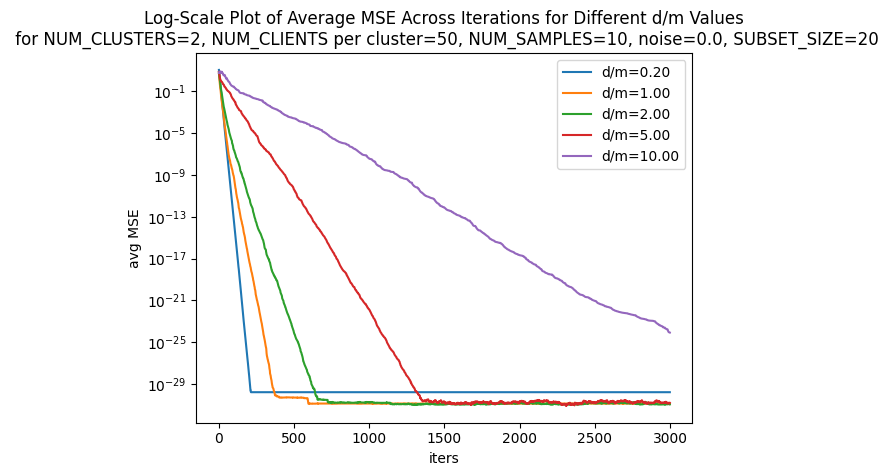

In [8]:
for item in range(len(d_over_m)):
    plt.plot([i for i in range(len(loss_dm_algo[item]))], loss_dm_algo[item], label='d/m=%.2f' % d_over_m[item])
plt.yscale('log')
plt.xlabel('iters')
plt.ylabel('avg MSE')
plt.legend()
plt.title(f"Log-Scale Plot of Average MSE Across Iterations for Different d/m Values\n for NUM_CLUSTERS={NUM_CLUSTERS}, NUM_CLIENTS per cluster={NUM_CLIENTS}, NUM_SAMPLES={NUM_SAMPLES}, noise=0.0, SUBSET_SIZE={SUBSET_SIZE}")
plt.show()

### Effect of noise in the algorithm performance

This part investigates the impact of varying noise levels on the performance of a persFL algorithm while maintaining a fixed feature-to-sample ratio of `d_over_m=2.0`. A list of noise levels is defined and the number of iterations for the algorithm `K` is set to 1500.

Within a loop that iterates over the noise levels, the code calculates the total number of features and generates synthetic data using the get_data function, incorporating the current noise level $\epsilon$. True model parameters are constructed by replicating weights for each client in their respective clusters. The algorithm is then executed on the generated dataset, and its loss history is recorded. This process allows for an analysis of how noise affects the algorithm's performance in a controlled setting.

In [9]:
# d_over_m = 0.2
d_over_m = 2.0
noises = [0.0, 0.05, 0.1, 0.2, 0.5, 0.7, 1.0]
loss_dm_algo=[]
loss_dm_ifca=[]
K = 1500

for i in range(len(noises)):  
#     print(d_over_m[i])
    num_features = int(NUM_SAMPLES * d_over_m)
    X, y, w, clusters = get_data(num_features=num_features, noise=noises[i])
    true_w = []
    for c in range(NUM_CLUSTERS):    
        true_w.extend([w[c] for i in range(NUM_CLIENTS)])
    true_w = np.array(true_w)

    _, algo_loss_history = algorithm(X, y, w, clusters, K, SUBSET_SIZE, alpha)
    loss_dm_algo.append(algo_loss_history)    

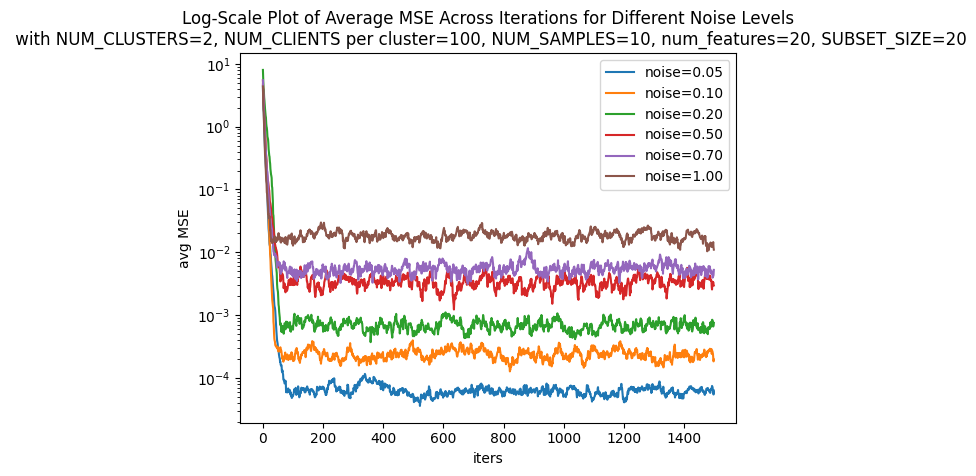

In [10]:
for item in range(len(noises)):
    if item == 0:
        continue
    plt.plot([i for i in range(len(loss_dm_algo[item]))], loss_dm_algo[item], label='noise=%.2f' % noises[item])
plt.yscale('log')
plt.xlabel('iters')
plt.ylabel('avg MSE')
plt.legend()
plt.title(f"Log-Scale Plot of Average MSE Across Iterations for Different Noise Levels\n with NUM_CLUSTERS={NUM_CLUSTERS}, NUM_CLIENTS per cluster={NUM_CLIENTS*2}, NUM_SAMPLES={NUM_SAMPLES}, num_features={int(NUM_SAMPLES * d_over_m)}, SUBSET_SIZE={SUBSET_SIZE}")
plt.show()

### Effect of sample size in the algorithm performance

This part, examines how different sample sizes influence the performance of a persFL algorithm. A list of subset sizes is defined, and a fixed feature-to-sample ratio of 2.0 is established. We conduct evaluations for various numbers of clients in the experiment.

For each subset size, it generates synthetic data five times to ensure robustness in the results. The total number of features is calculated based on the number of samples and the defined ratio. The `get_data` function is called to create the dataset, which includes features, target values, model parameters, and cluster information. Finally, the algorithm is executed on the generated dataset, and the resulting loss history is recorded for each subset size. This process allows for a detailed analysis of how varying sample sizes affect the algorithm's performance.


#### For N = 100

In [11]:
from collections import defaultdict
subset_sizes = [5, 10, 15, 20, 30]
d_over_m = 2.0
loss_dm_algo = defaultdict(list)
num_clients = 50

for i in range(len(subset_sizes)):  
    subset_size = subset_sizes[i]
    
    for _ in range(5):
    
        num_features = int(NUM_SAMPLES * d_over_m)
        X, y, w, clusters = get_data(num_features=num_features, num_clients=num_clients)
        true_w = []
        for c in range(NUM_CLUSTERS):    
            true_w.extend([w[c] for i in range(NUM_CLIENTS)])
        true_w = np.array(true_w)

        _, algo_loss_history = algorithm(X, y, w, clusters, K, subset_size, alpha)
        loss_dm_algo[subset_size].append(algo_loss_history)    

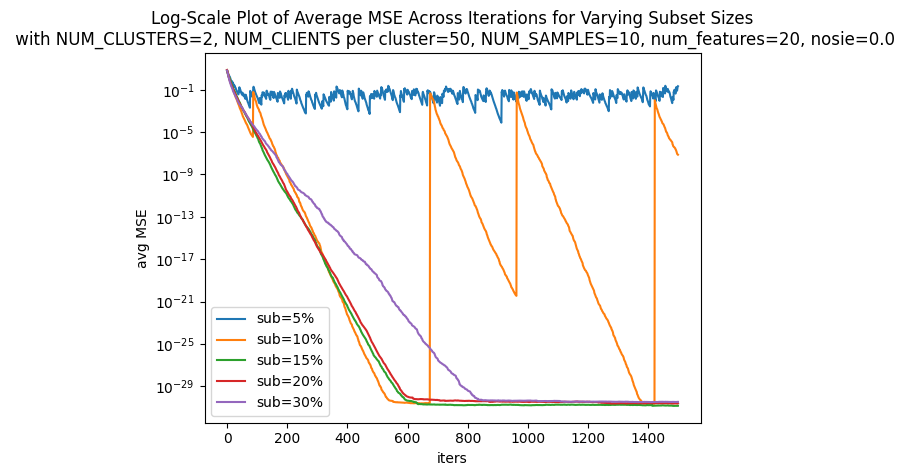

In [12]:
for subset_size in subset_sizes:
    sub_frac = (subset_size*100)/(NUM_CLUSTERS*NUM_CLIENTS)
    scores = np.array(loss_dm_algo[subset_size])
    scores = np.mean(scores, axis=0)
    plt.plot([i for i in range(len(scores))], scores, label='sub=%d%%' % sub_frac)
plt.yscale('log')
plt.xlabel('iters')
plt.ylabel('avg MSE')
plt.legend()
plt.title(f"Log-Scale Plot of Average MSE Across Iterations for Varying Subset Sizes\n with NUM_CLUSTERS={NUM_CLUSTERS}, NUM_CLIENTS per cluster={num_clients}, NUM_SAMPLES={NUM_SAMPLES}, num_features={int(NUM_SAMPLES * d_over_m)}, nosie=0.0")
plt.show()

#### For N = 200

In [13]:
subset_sizes = [5, 10, 20, 30, 40, 50, 60]
d_over_m = 0.2
loss_dm_algo = defaultdict(list)
num_clients = 100

for i in range(len(subset_sizes)):  
    subset_size = subset_sizes[i]
    
    for _ in range(5):
    
        num_features = int(NUM_SAMPLES * d_over_m)
        X, y, w, clusters = get_data(num_features=num_features, num_clients=num_clients)
        true_w = []
        for c in range(NUM_CLUSTERS):    
            true_w.extend([w[c] for i in range(num_clients)])
        true_w = np.array(true_w)

        _, algo_loss_history = algorithm(X, y, w, clusters, K, subset_size, alpha)
        loss_dm_algo[subset_size].append(algo_loss_history)    

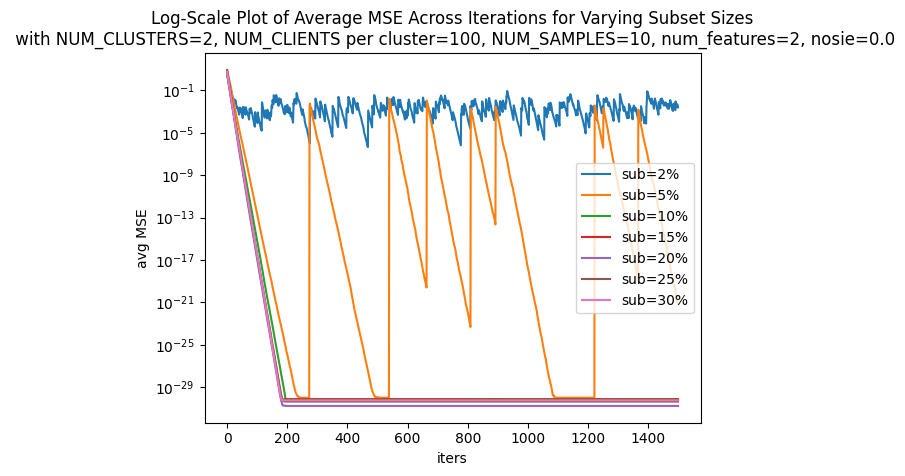

In [14]:
for subset_size in subset_sizes:
    sub_frac = (subset_size*100)/(NUM_CLUSTERS*num_clients)
    scores = np.array(loss_dm_algo[subset_size])
    scores = np.mean(scores, axis=0)
    plt.plot([i for i in range(len(scores))], scores, label='sub=%d%%' % sub_frac)
plt.yscale('log')
plt.xlabel('iters')
plt.ylabel('avg MSE')
plt.title(f"Log-Scale Plot of Average MSE Across Iterations for Varying Subset Sizes\n with NUM_CLUSTERS={NUM_CLUSTERS}, NUM_CLIENTS per cluster={num_clients}, NUM_SAMPLES={NUM_SAMPLES}, num_features={int(NUM_SAMPLES * d_over_m)}, nosie=0.0")
plt.legend()
plt.show()

#### For N = 400

In [15]:
subset_sizes = [10, 20, 30, 40, 50, 60]
d_over_m = 0.2
loss_dm_algo = defaultdict(list)
num_clients = 200


for i in range(len(subset_sizes)):  
    subset_size = subset_sizes[i]
    
    for _ in range(5):
    
        num_features = int(NUM_SAMPLES * d_over_m)
        X, y, w, clusters = get_data(num_features=num_features, num_clients=num_clients)
        true_w = []
        for c in range(NUM_CLUSTERS):    
            true_w.extend([w[c] for i in range(num_clients)])
        true_w = np.array(true_w)

        _, algo_loss_history = algorithm(X, y, w, clusters, K, subset_size, alpha)
        loss_dm_algo[subset_size].append(algo_loss_history)    

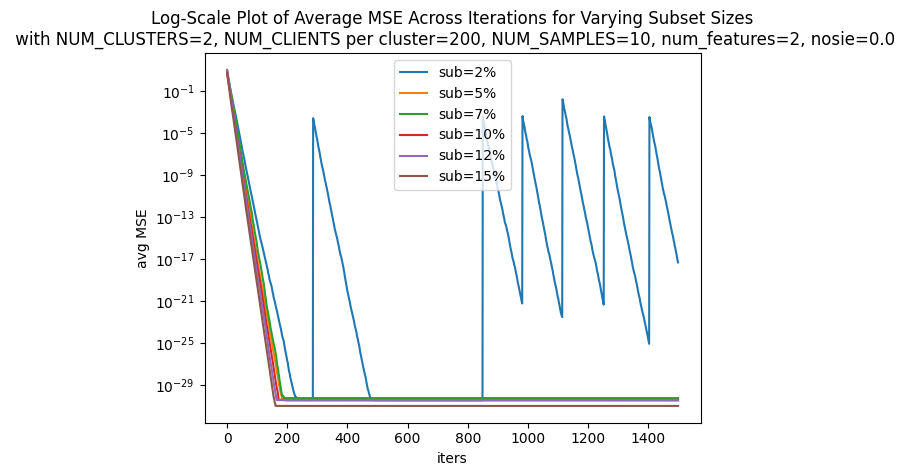

In [16]:
for subset_size in subset_sizes:
    sub_frac = (subset_size*100)/(NUM_CLUSTERS*num_clients)
    scores = np.array(loss_dm_algo[subset_size])
    scores = np.mean(scores, axis=0)
    plt.plot([i for i in range(len(scores))], scores, label='sub=%d%%' % sub_frac)
plt.yscale('log')
plt.xlabel('iters')
plt.ylabel('avg MSE')
plt.title(f"Log-Scale Plot of Average MSE Across Iterations for Varying Subset Sizes\n with NUM_CLUSTERS={NUM_CLUSTERS}, NUM_CLIENTS per cluster={num_clients}, NUM_SAMPLES={NUM_SAMPLES}, num_features={int(NUM_SAMPLES * d_over_m)}, nosie=0.0")
plt.legend()
plt.show()

### Sinus data


The function `get_sin_data` generates synthetic sinusoidal data for a specified number of clients and training samples. It takes three parameters: `num_clients`, which sets the number of data nodes; `num_training_samples`, determining how many samples each node will generate; and `noise`, which adds random variability to the sinusoidal output.

The function first calculates the width of the intervals based on the specified range of -10 to 10, dividing this range into equal segments for each client. It then creates an array of input values $X$ and corresponding output values $y$. 

1. **Input $x$**:
   - For each client $i$ (where $i = 0, 1, \ldots, num\_clients - 1$):
   $$
   x_{i,j} = \text{start}_i + j \cdot \Delta x \quad \text{for } j = 0, 1, \ldots, num\_training\_samples - 1
   $$
   where:
   $$
   \Delta x = \frac{(\text{end}_i - \text{start}_i)}{num\_training\_samples - 1}
   $$
   defines the spacing between consecutive $x$ values, and
   $$
   \text{start}_i = -10 + i \cdot \frac{20}{num\_clients} \quad \text{and} \quad \text{end}_i = \text{start}_i +  \frac{20}{num\_clients}
   $$
   define the interval for each client.

2. **Output $y$**:
   - For each client $i$:
   $$
   y_{i,j} = \sin(x_{i,j}) + \epsilon_{i,j} \quad \text{for } j = 0, 1, \ldots, num\_training\_samples - 1
   $$
   where:
   - $\epsilon_{i,j}$ is a random variable drawn from a normal distribution with mean $0$ and standard deviation equal to the specified `noise` parameter, representing the added variability to simulate real-world scenarios.

By applying the sine function to the generated $x$ values and incorporating noise, the function produces realistic data points. The function returns the generated input-output pairs $X$ and $y$, along with `None` for the additional outputs that are not used in this context (weight vectors and cluster information).


In [17]:
def get_sin_data(num_clients=NUM_CLIENTS, num_training_samples=NUM_SAMPLES, noise=0.0, size=3):
    interval_width = (size - (-size)) / num_clients

    # Generate the intervals
    intervals = [(i * interval_width-size, (i + 1) * interval_width-size) for i in range(num_clients)]

    # Generate data for each node
    X = np.zeros((num_clients,num_training_samples, 1)) 
    y = np.zeros ((num_clients,num_training_samples))
    for i, (start, end) in enumerate(intervals):
        x = np.linspace(start, end, num_training_samples)
        X[i] = x.reshape(-1, 1)
        y[i] = np.sin(x) + np.random.normal(0, noise, len(X[i]))
    
    
    return X, y, None, None


This code segment examines the performance of a persFL algorithm using synthetic sinusoidal data generated for varying numbers of clients. It initializes a list of clients with values [10, 20, 30, 40, 50].

For each `num_clients` in the clients list, it generates synthetic sinusoidal data using the `get_sin_data` function with 10 training samples per client. For the first `num_clients`, the code visualizes the generated data by creating a scatter plot of the feature values 
`X` against the labels `y`. 

After visualizing the data, the algorithm is executed using the generated dataset and a fixed number of iterations (100), and a subset size equal to half the number of clients. This process allows for the analysis of how varying the number of clients impacts the algorithm's performance on noisy sinusoidal data.

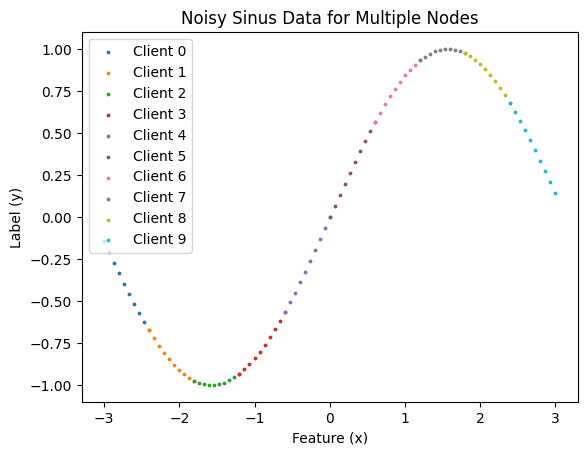

In [18]:
clients = [10, 20, 30, 40, 50]
loss_dm_algo=[]
for s in range(len(clients)):  
    num_clients = clients[s]
    X, y, w, clusters = get_sin_data(num_clients=num_clients, num_training_samples=10)
    if s == 0:
        for i in range(len(X)):
            plt.scatter(X[i], y[i], s=3.0, label=f'Client {i}')
        plt.xlabel('Feature (x)')
        plt.ylabel('Label (y)')
        plt.title('Noisy Sinus Data for Multiple Nodes')
        plt.legend()
        plt.show()
    
    _, algo_loss_history = algorithm(X, y, w, clusters, 100, num_clients//2, alpha, loss_model='y')
    loss_dm_algo.append(algo_loss_history)    


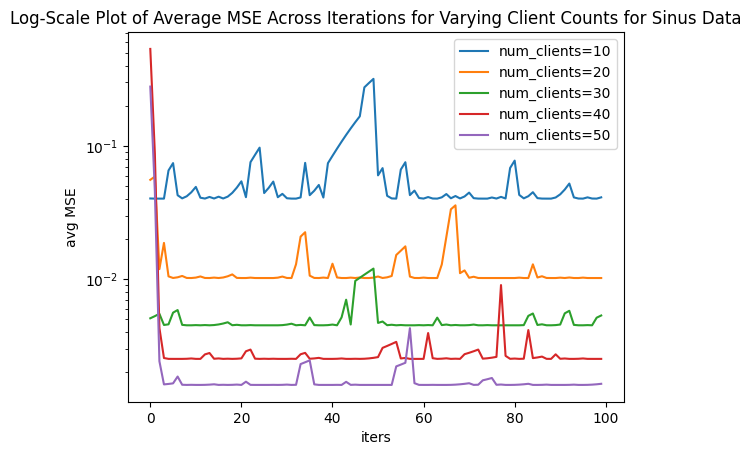

In [19]:
for item in range(len(clients)):
    plt.plot([i for i in range(len(loss_dm_algo[item]))], loss_dm_algo[item], label='num_clients=%d' % clients[item])
plt.yscale('log')
plt.xlabel('iters')
plt.ylabel('avg MSE')
plt.title(f"Log-Scale Plot of Average MSE Across Iterations for Varying Client Counts for Sinus Data")
plt.legend()
plt.show()

This part explores the influence of varying sample sizes on the performance of a PersFL algorithm using synthetic sinusoidal data. It initializes a list of sample sizes—[5, 10, 20, 30]—and sets the number of clients to 10. For each sample size, the code generates data through the `get_sin_data` function, which produces input-output pairs for the specified number of clients and samples.

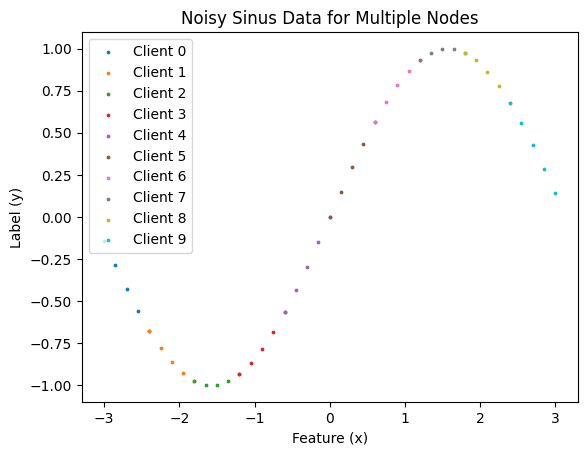

In [20]:
samples = [5, 10, 20, 30]
loss_dm_algo=[]
num_clients = 10
for s in range(len(samples)):  
    num_samples = samples[s]
    X, y, w, clusters = get_sin_data(num_clients=num_clients, num_training_samples=num_samples)
    if s == 0:
        for i in range(len(X)):
            plt.scatter(X[i], y[i], s=3.0, label=f'Client {i}')
        plt.xlabel('Feature (x)')
        plt.ylabel('Label (y)')
        plt.title('Noisy Sinus Data for Multiple Nodes')
        plt.legend()
        plt.show()
    
    _, algo_loss_history = algorithm(X, y, w, clusters, 100, num_clients//2, alpha, loss_model='y')
    loss_dm_algo.append(algo_loss_history)    


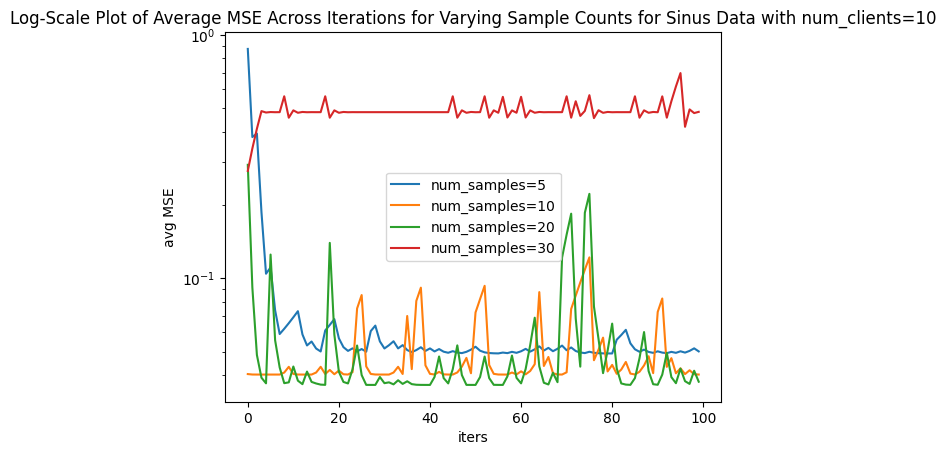

In [21]:
for item in range(len(samples)):
    plt.plot([i for i in range(len(loss_dm_algo[item]))], loss_dm_algo[item], label='num_samples=%d' % samples[item])
plt.yscale('log')
plt.xlabel('iters')
plt.ylabel('avg MSE')
plt.title(f"Log-Scale Plot of Average MSE Across Iterations for Varying Sample Counts for Sinus Data with num_clients={num_clients}")
plt.legend()
plt.show()

### FedeRiCo Algorithm: Personalized Federated Learning with the Right Collaborators

This code implements the **FedeRiCo** algorithm from the paper "Find Your Friends: Personalized Federated Learning with the Right Collaborators". The FedeRiCo framework is designed for decentralized, personalized federated learning, where each client can collaborate with other clients based on data similarity, without relying on a centralized server. The goal is to allow each client to learn from others in an optimal way, accounting for local data distribution, in order to outperform both centralized and purely local training methods.

**Key Components:**
1. **Epsilon-Greedy Neighbor Sampling:** 
   Clients select collaborators (neighbors) for model training using an epsilon-greedy approach. With probability `epsilon`, a random collaborator is chosen, otherwise the one with the highest collaboration weight is selected.
   
2. **E-step (Expectation Step):**
   Clients calculate the weighted loss of models from their neighbors (collaborators) and update the collaboration weights using an exponential moving average and softmax. The loss is based on the difference between actual and predicted outputs.

3. **M-step (Maximization Step):**
   Each client updates their model parameters using weighted gradients from their selected neighbors' models, employing gradient descent for optimization.

4. **Main Loop:**
   The process iterates over a number of rounds where clients:
   - Select collaborators using the epsilon-greedy strategy.
   - Update collaboration weights based on the performance of their neighbors' models (E-step).
   - Update their own models using gradient information from their collaborators (M-step).

This implementation shows how personalized federated learning can be achieved without a central coordinator, allowing clients to learn from one another while addressing data heterogeneity. The result is a personalized model for each client that leverages the right collaborators.

In [22]:
# Epsilon-greedy neighbor sampling
def epsilon_greedy_selection(weights, epsilon, num_neighbors):
    """ Selects neighbors using epsilon-greedy strategy based on the collaboration weights. """
    neighbors = []
    for i in range(num_neighbors):
        if np.random.rand() < epsilon:
            neighbors.append(np.random.choice(len(weights)))  # Random neighbor
        else:
            neighbors.append(np.argmax(weights))  # Best neighbor based on weights
    return neighbors

# E-step: Compute the posterior probability of each client choosing others as collaborators
def e_step(X, y, w, clients_models, num_clients, neighbors, beta, prev_losses, prev_weighted_losses):
    updated_losses = np.copy(prev_losses)
    updated_weighted_losses = np.copy(prev_weighted_losses)
    
    for i in range(num_clients):
        for neighbor in neighbors[i]:
            # Update loss for sampled neighbors
            y_pred = X[i] @ clients_models[neighbor]
            loss = np.mean((y[i] - y_pred) ** 2)
            updated_losses[i][neighbor] = loss
        
        # Exponential moving average for loss
        updated_weighted_losses[i] = (1 - beta) * prev_weighted_losses[i] + beta * updated_losses[i]

        # Update weights using softmax
        w[i] = np.exp(-updated_weighted_losses[i]) / np.sum(np.exp(-updated_weighted_losses[i]))
    
    return w, updated_losses, updated_weighted_losses

# M-step: Update models based on weighted collaborations
def m_step(X, y, w, clients_models, num_clients, neighbors, learning_rate):
    for i in range(num_clients):
        total_grad = np.zeros(clients_models[i].shape)
        
        for neighbor in neighbors[i]:
            grad = X[i].T @ (X[i] @ clients_models[neighbor] - y[i])  # Gradient of loss function
            total_grad += w[i][neighbor] * grad
        
        # Update the model using gradient descent
        clients_models[i] -= learning_rate * total_grad / len(y[i])
    
    return clients_models

# Main FedeRiCo algorithm
def federico(X, y, num_clients, num_features, num_rounds=1000, num_neighbors=3, epsilon=0.3, beta=0.6, learning_rate=0.01):
    clients_models = np.random.randn(num_clients, num_features)  # Initialize models
    w = np.ones((num_clients, num_clients)) / num_clients  # Initialize uniform weights
    prev_losses = np.zeros((num_clients, num_clients))  # Initialize previous losses
    prev_weighted_losses = np.zeros((num_clients, num_clients))  # Initialize exponential moving avg losses

    for t in range(num_rounds):
        # Epsilon-greedy selection of neighbors
        neighbors = [epsilon_greedy_selection(w[i], epsilon, num_neighbors) for i in range(num_clients)]
        
        # E-step: Update the collaboration weights and losses
        w, prev_losses, prev_weighted_losses = e_step(X, y, w, clients_models, num_clients, neighbors, beta, prev_losses, prev_weighted_losses)
        
        # M-step: Update models based on collaboration weights
        clients_models = m_step(X, y, w, clients_models, num_clients, neighbors, learning_rate)
    
    return clients_models, w





In [25]:
num_clients = 6
num_samples = 50
num_features = 1
X, y, _, _ = get_sin_data(num_clients=num_clients, num_training_samples=num_samples, noise=0.1)

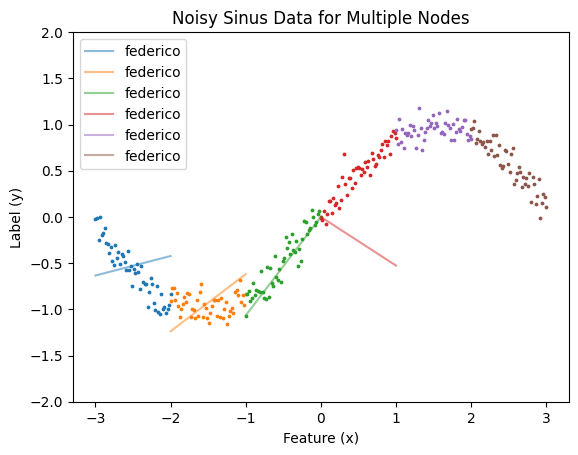

In [26]:
# Run FedeRiCo algorithm
federico_w, weights = federico(X, y, num_clients, num_features, num_rounds=1000)

for i in range(len(X)):
    plt.scatter(X[i], y[i], s=3.0)
    plt.plot(X[i], X[i] * federico_w[i], alpha=0.5, label='federico')

plt.xlabel('Feature (x)')
plt.ylabel('Label (y)')
plt.title('Noisy Sinus Data for Multiple Nodes')
plt.ylim(-2, 2)
plt.legend()
plt.show()

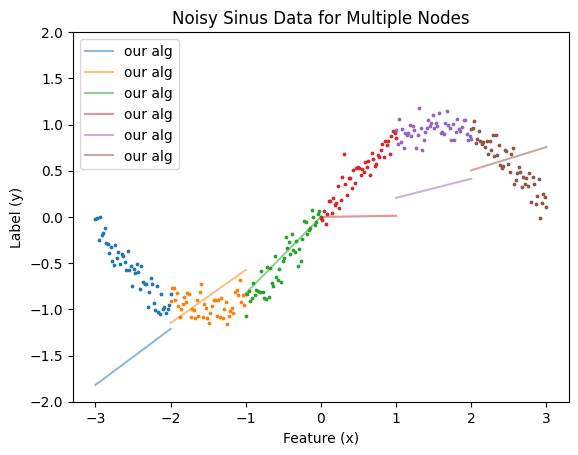

In [28]:
# Run our algorithm
w_hat, algo_loss_history = algorithm(X, y, w, clusters, 1000, num_clients//2, alpha, loss_model='y')

for i in range(len(X)):
    plt.scatter(X[i], y[i], s=3.0)
    plt.plot(X[i], X[i] * w_hat[i], alpha=0.5, label='our alg')

plt.xlabel('Feature (x)')
plt.ylabel('Label (y)')
plt.title('Noisy Sinus Data for Multiple Nodes')
plt.ylim(-2, 2)
plt.legend()
plt.show()

